### Patch-Match

data to test: https://github.com/mdavydov/ComputerVisionCourse/tree/master/frames

paper: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf

https://en.wikipedia.org/wiki/PatchMatch

video: https://www.youtube.com/watch?v=fMe19oTz6vk

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import io
import scipy.stats as stats
import sys
import random

def cv2_imshow(img):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.show()
    
def url_to_image(url):
    print("downloading %s" % (url))
    image = io.imread(url)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [29]:
# https://docs.opencv.org/3.3.1/d7/d8b/tutorial_py_lucas_kanade.html

def display_offset_field(img1,img2,offset_field):
    fig=plt.figure(figsize=(24, 24))
    fig.add_subplot(4, 4, 1)
    plt.imshow(img1, cmap = 'gray', interpolation = 'bicubic')
    fig.add_subplot(4, 4, 2)
    plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
    plt.show()

    img = url_to_image('https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg')
    img = cv2.resize(img, img1.shape, interpolation = cv2.INTER_AREA)
    hsv = np.zeros_like(img)
    hsv[...,1] = 255


    x = np.arange(0, img1.shape[0], 1)
    y = np.arange(0, img1.shape[1], 1)
    xx, yy = np.meshgrid(x, y)

    mag, ang = cv2.cartToPolar((offset_field[:,:,0] - yy).flatten().astype('float64'), 
                               (offset_field[:,:,1] - xx).flatten().astype('float64'), angleInDegrees=True)
    hsv[...,0] = (ang).reshape(img1.shape)
    hsv[...,2] = (cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)).reshape(img1.shape)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    cv2_imshow(bgr)

In [23]:
patch_size = 2

def reconstruct_image(offset_field, img):
    new_img = np.zeros(img.shape)
    
    for x in range(offset_field.shape[0]):
        for y in range(offset_field.shape[1]):
            if x < patch_size or img.shape[0] < x + patch_size or y < patch_size or img.shape[1] < y + patch_size:
                new_img[x, y] = 0
            else: 
                new_img[x, y] = img[offset_field[x,y,0], offset_field[x,y,1]]
            
    return new_img

def find_best_match(patch1, matches, img2):
    # fill distance
    for match in matches:
        x2 = match[3]
        y2 = match[4]

        if x2 < patch_size or img2.shape[0] < x2 + patch_size or y2 < patch_size or img2.shape[1] < y2 + patch_size:
            continue

        patch2 = img2[x2-patch_size:x2+patch_size,y2-patch_size:y2+patch_size]
        # update distance
        match[2] = np.linalg.norm(patch1-patch2)
    # find the closest patch
    matches = sorted(matches, key=lambda match: match[2])
    
    return (matches[0][3], matches[0][4])
    

def propagation(patch1, x,y, img2, offset_field, k):
    # find match on another image
    matches = [
        [offset_field[x,y,0], offset_field[x,y,1], sys.maxsize, offset_field[x,y,0], offset_field[x,y,1]], # f(x,y)
        [offset_field[x+k,y,0], offset_field[x+k,y,1], sys.maxsize, offset_field[x+k,y,0] - k, offset_field[x+k,y,1]], # f(x-+1,y)
        [offset_field[x,y+k,0], offset_field[x,y+k,1], sys.maxsize, offset_field[x,y+k,0], offset_field[x,y+k,1] - k] # f(x,y-+1)  
    ]
    
    return find_best_match(patch1, matches, img2)

def random_search1(patch1, x,y, img2, offset_field):
    number_of_try = 20
    lower, upper = 0, img2.shape[0]-1
    sigma = 1
    mux = x
    muy = y
    x2s = stats.truncnorm.rvs((lower - mux) / sigma, (upper - mux) / sigma, loc=mux, scale=sigma,size=number_of_try)
    y2s = stats.truncnorm.rvs((lower - muy) / sigma, (upper - muy) / sigma, loc=muy, scale=sigma,size=number_of_try)
    
    matches = [
        [offset_field[x,y,0], offset_field[x,y,1], sys.maxsize, offset_field[x,y,0], offset_field[x,y,1]],
    ]
    
    k = 1 if random.random() < 0.5 else -1
    for n in range(number_of_try):
        matches.append([offset_field[int(x2s[n]),int(y2s[n]),0], 
                        offset_field[int(x2s[n]),int(y2s[n]),1],
                            sys.maxsize, 
                            offset_field[int(x2s[n]),int(y2s[n]),0] + k,
                            offset_field[int(x2s[n]),int(y2s[n]),1] - k])
    
    return find_best_match(patch1, matches, img2)

def random_search(patch1, x,y, img2, offset_field):
    number_of_try = 20
    lower, upper = 0, img2.shape[0]-1
    sigma = 1
    mux = offset_field[x,y,0]
    muy = offset_field[x,y,1]
    x2s = stats.truncnorm.rvs((lower - mux) / sigma, (upper - mux) / sigma, loc=mux, scale=sigma,size=number_of_try)
    y2s = stats.truncnorm.rvs((lower - muy) / sigma, (upper - muy) / sigma, loc=muy, scale=sigma,size=number_of_try)
    
    matches = [
        [offset_field[x,y,0], offset_field[x,y,1], sys.maxsize, offset_field[x,y,0], offset_field[x,y,1]],
    ]
    
    for n in range(number_of_try):
        matches.append([int(x2s[n]), int(y2s[n]), sys.maxsize, int(x2s[n]), int(y2s[n])])
    
    return find_best_match(patch1, matches, img2)

def random_search2(patch1, x,y, img2, offset_field):
    matches = [
        [offset_field[x,y,0], offset_field[x,y,1], sys.maxsize, offset_field[x,y,0], offset_field[x,y,1]],
    ]
    
    #wx = abs(img2.shape[0] - 1 - x)
    #wy = abs(img2.shape[1] - 1 - y)
    alfa = 1/2
    i=0
    wx = wy = int(np.hypot(img2.shape[0],img2.shape[1]))
    while wx*(alfa**i) > 1 and wy*(alfa**i) > 1:
        x1 = int(x + wx*(alfa**i)+np.random.uniform(-1,1,1))
        y1 = int(y + wy*(alfa**i)+np.random.uniform(-1,1,1))

        matches.append([x1, y1, sys.maxsize, x1, y1])
        #matches.append([offset_field[x1,y1,0], offset_field[x1,y1,1], sys.maxsize, offset_field[x1,y1,0], offset_field[x1,y1,1]])
        i+=1
    
    return find_best_match(patch1, matches, img2)


def patch_match(img1, img2, num_iterations = 5):
    offset_field = np.random.randint(img1.shape[0], size=(img1.shape[0], img1.shape[1], 2))  
    
    # Fix randomnes around borders. Preserve pixels around borders.
    for x1 in range(offset_field.shape[0]):
        for y1 in range(offset_field.shape[1]):
            # validate borders, patch should not exide the size of image
            if x1 < patch_size or img1.shape[0] < x1 + patch_size or y1 < patch_size or img1.shape[1] < y1 + patch_size:
                offset_field[x1,y1,0] = x1
                offset_field[x1,y1,1] = y1
    
    reconstructed = reconstruct_image(offset_field, img2)
    cv2_imshow(reconstructed)
    error = np.linalg.norm(reconstructed - img1)
    print('error:', int(error))

    for k in range(num_iterations):
        t = 0 
        for x1 in range(offset_field.shape[0]):
            for y1 in range(offset_field.shape[1]):
                # validate borders, patch should not exide the size of image
                if x1 < patch_size or img1.shape[0] < x1 + patch_size or y1 < patch_size or img1.shape[1] < y1 + patch_size:
                    continue
                # get current patch
                patch1 = img1[x1-patch_size:x1+patch_size,y1-patch_size:y1+patch_size]

                # Propagation
                t+=1
                k = 1 if t % 2 == 0 else -1

                if offset_field.shape[0] == x1+k or offset_field.shape[1] == y1+k or x1+k < 0 or y1+k < 0:
                    continue

                match = propagation(patch1, x1, y1, img2, offset_field, k)
                offset_field[x1,y1,0] = match[0]
                offset_field[x1,y1,1] = match[1]
                
                # Random search
                match = random_search2(patch1, x1, y1, img2, offset_field)
                offset_field[x1,y1,0] = match[0]
                offset_field[x1,y1,1] = match[1]
                

        reconstructed = reconstruct_image(offset_field, img2)
        cv2_imshow(reconstructed)
        error = np.linalg.norm(reconstructed - img1)
        print('error:', int(error))
        
    return offset_field

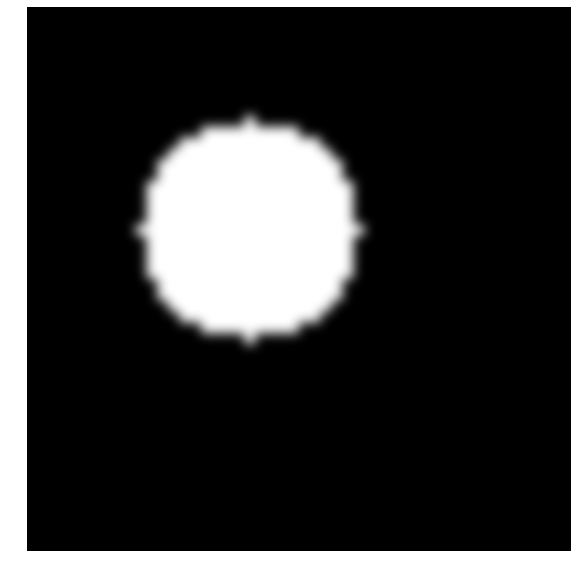

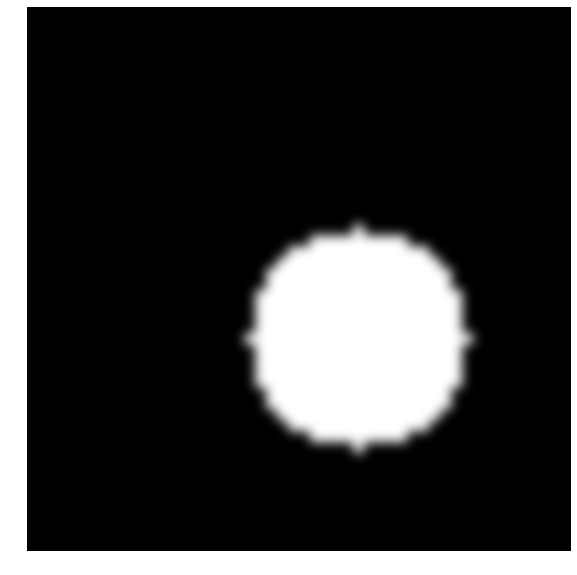

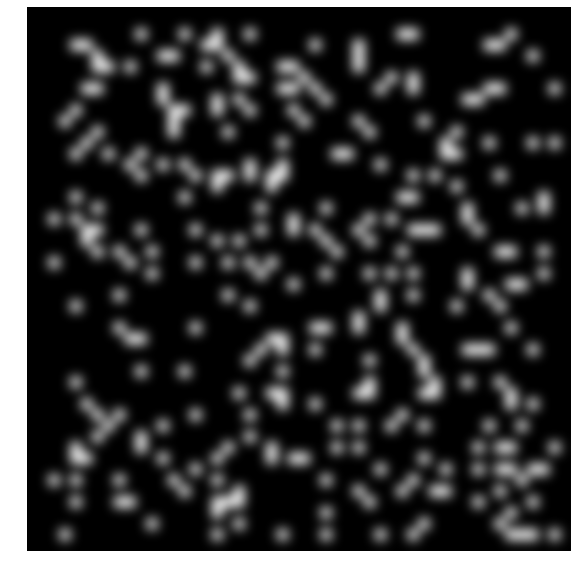

error: 5909


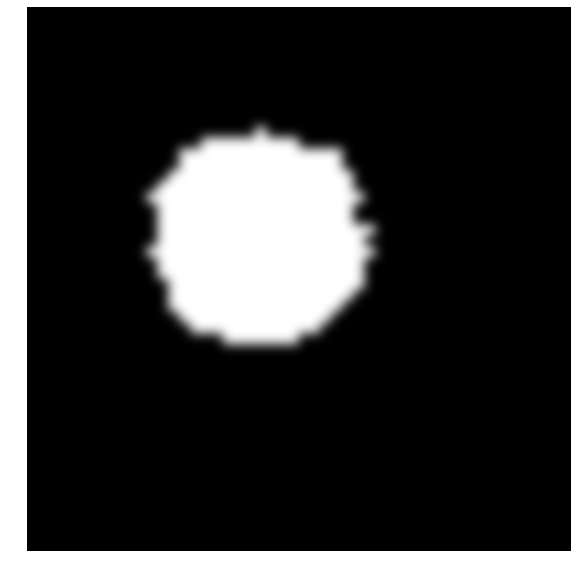

error: 1803


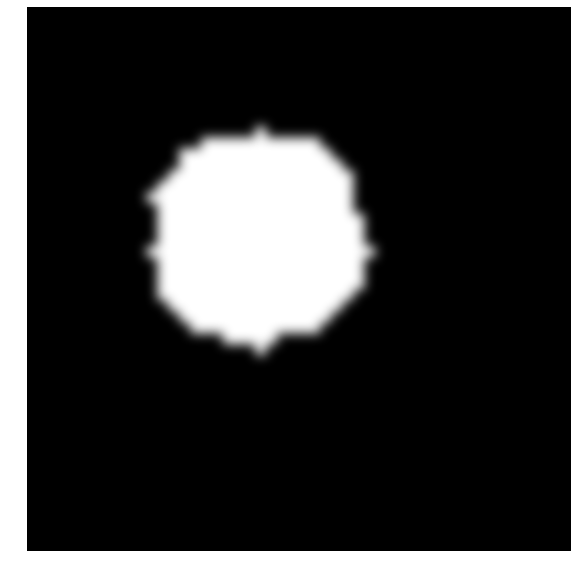

error: 1672


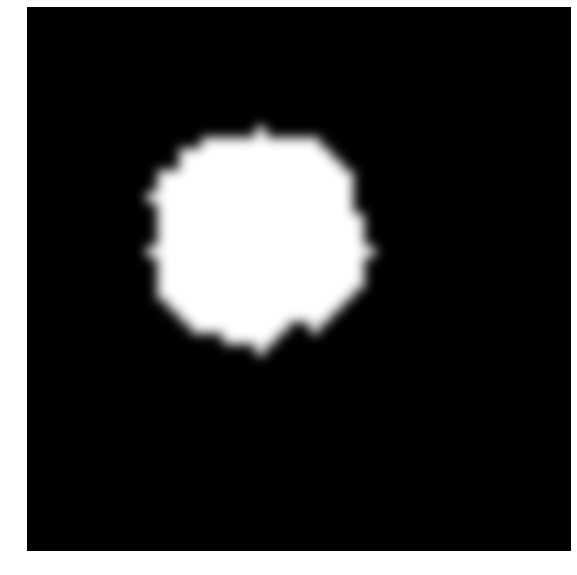

error: 1652


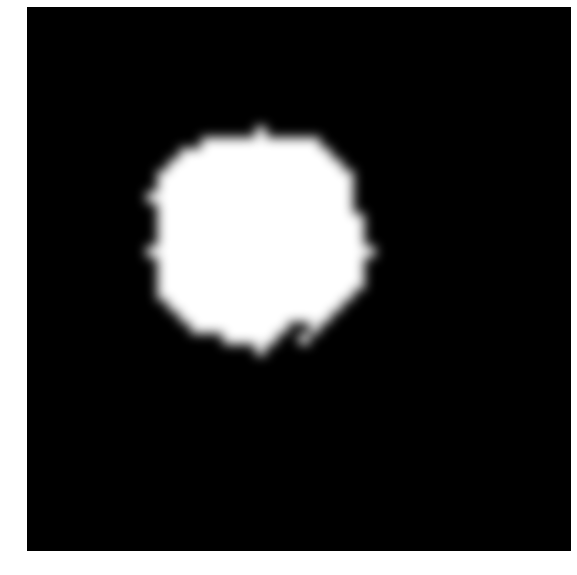

error: 1652


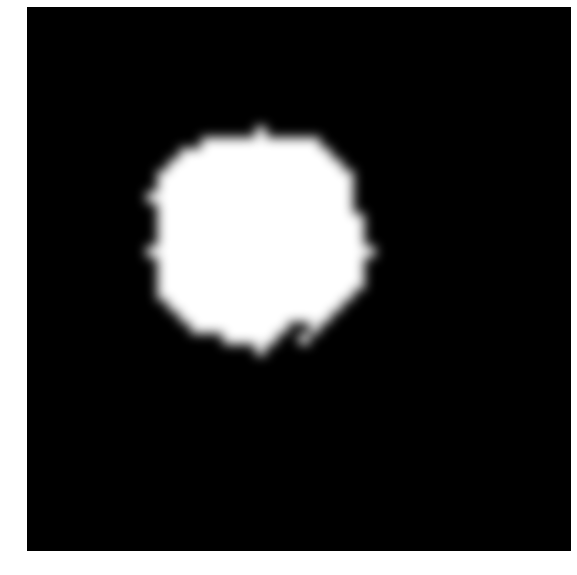

error: 1652


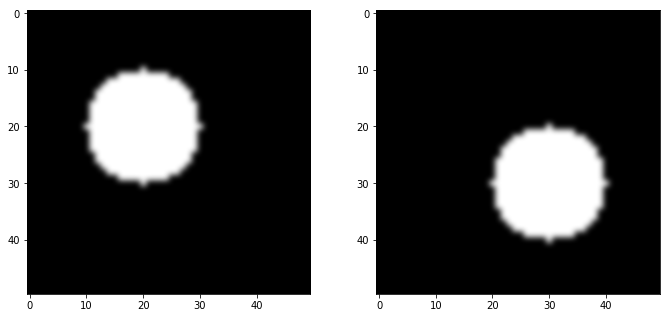

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  27 ...   7   6   0]
 ...
 [  0   0 -19 ... -43   0   0]
 [  0   0  -7 ... -24   0   0]
 [  0   0   0 ...   0   0   0]]
[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [47 47 47 ... 47 47 47]
 [48 48 48 ... 48 48 48]
 [49 49 49 ... 49 49 49]]


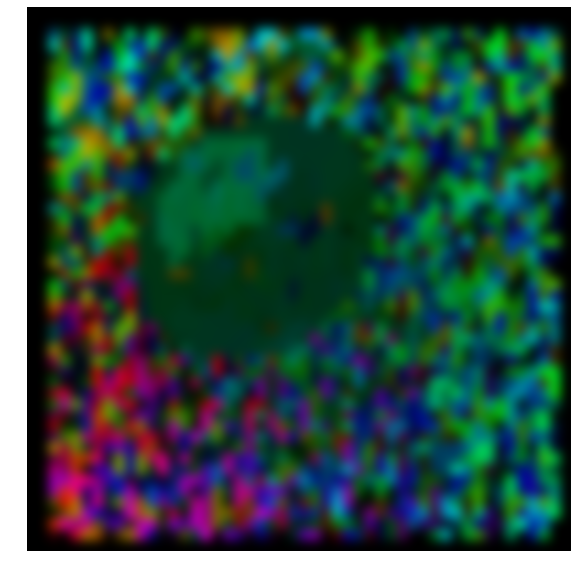

In [28]:
img1 = np.zeros((50,50), dtype=np.int32)
cv2.circle(img1,(20,20), 10, (255,255,255), -1)
cv2_imshow(img1)

img2 = np.zeros((50,50), dtype=np.int32)
cv2.circle(img2,(20+10,20+10), 10, (255,255,255), -1)
cv2_imshow(img2)

offset_field = patch_match(img1, img2, num_iterations = 5)

display_offset_field(img1,img2,offset_field)

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg
downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v020.jpg


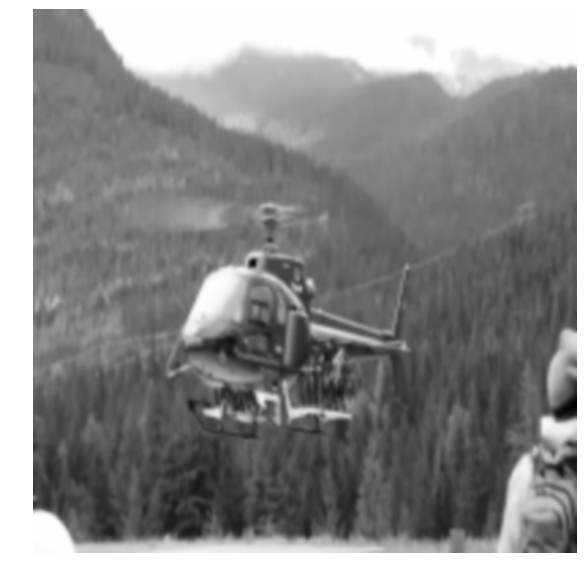

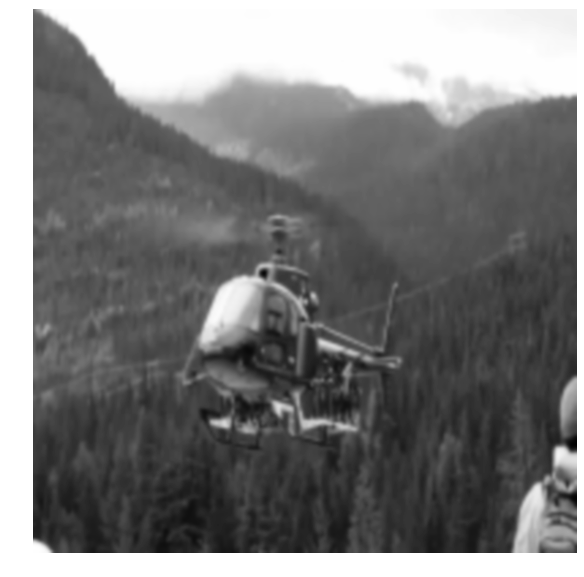

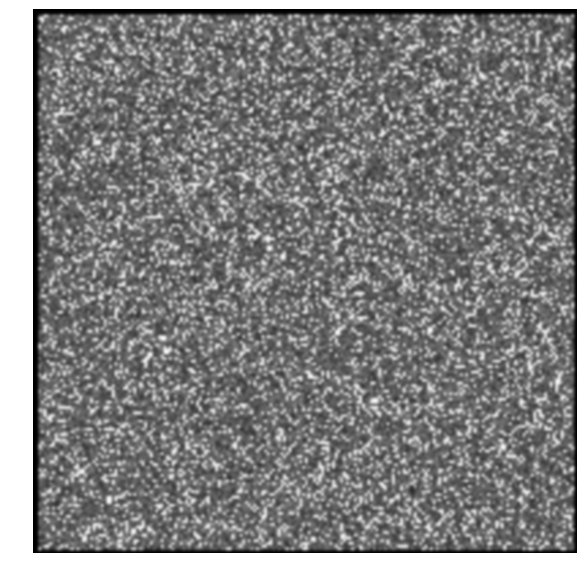

error: 17459


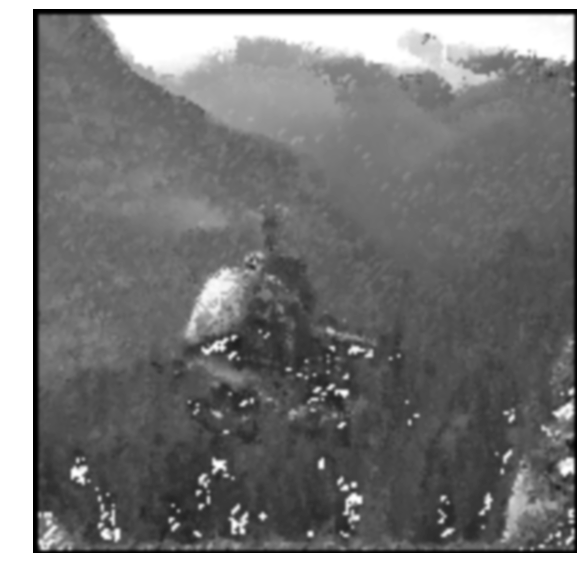

error: 10431


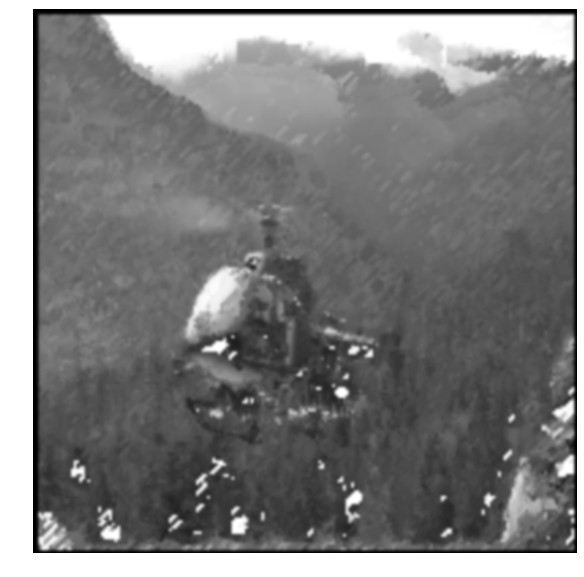

error: 9986


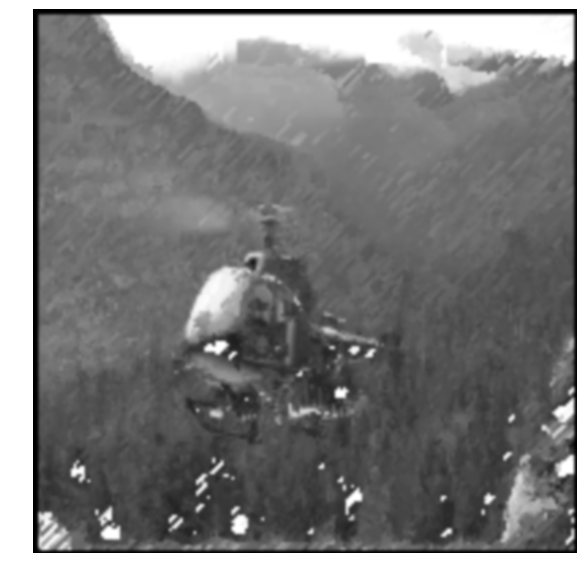

error: 9803


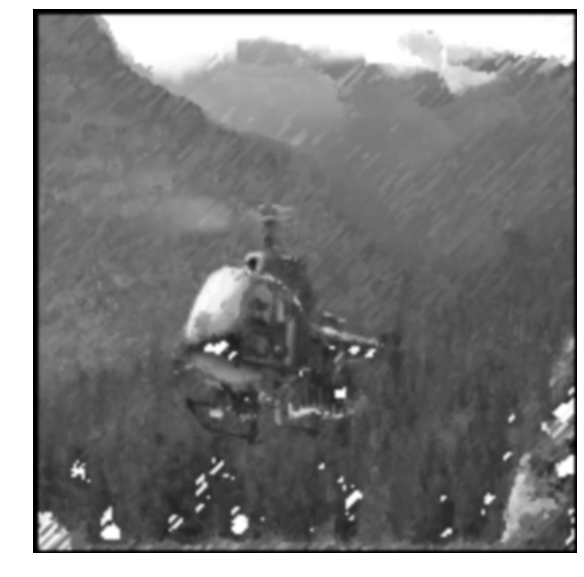

error: 9708


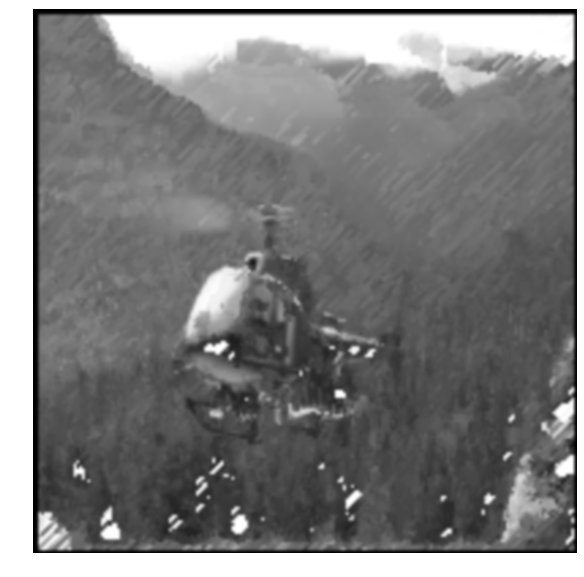

error: 9658


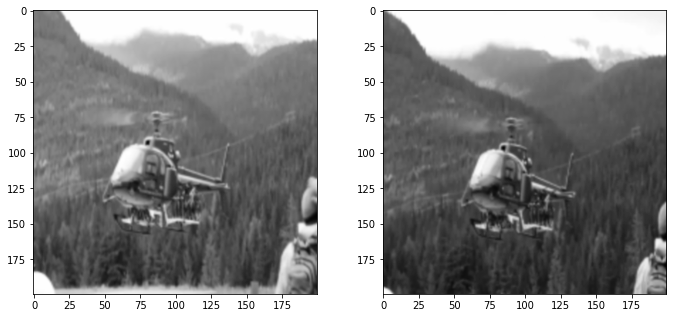

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg


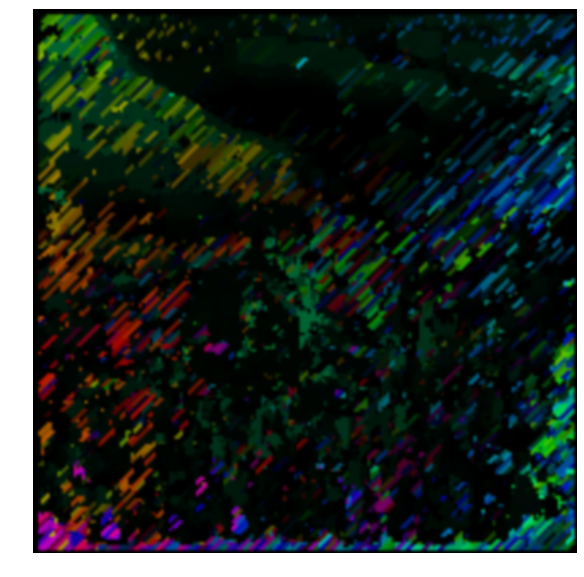

In [30]:
img1 = url_to_image('https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v010.jpg')
img2 = url_to_image('https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v020.jpg')

img1 = cv2.resize(img1, (200,200), interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, (200,200), interpolation = cv2.INTER_AREA)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

cv2_imshow(img1)
cv2_imshow(img2)

offset_field = patch_match(img1, img2, num_iterations = 5)

display_offset_field(img1,img2,offset_field)

In [6]:
a = np.ones((5,5))
np.lib.pad(a, (2,2), 'constant', constant_values=(0,0))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
a = np.array([-1,-4,-1])
b = np.array([-2,-5,-1])
np.linalg.norm(a-b)

1.4142135623730951

In [8]:
x = np.arange(0, 5, 1)
y = np.arange(0, 5, 1)
xx, yy = np.meshgrid(x, y)

In [9]:
yy

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [21]:
xx

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])